# Actividad 2: Reconocimiento de imagenes más complejas utilizando redes neuronales convolucionales.

En esta actividad se llevará el reconocimiento de imagenes al siguiente nivel, reconociendo imágenes reales de Gatos y Perros para clasificar una imagen entrante como una u otra. En particular, algunos dataset como el reconocimiento de la escritura a mano agilizará el proceso al hacer que todas las imágenes tengan el mismo tamaño y forma, y todas fueran monocromo. Las imágenes del mundo real no son así... tienen diferentes formas, proporciones de aspecto, etc., ¡y normalmente son en color!

Así que, como parte de la tarea necesaria para el proceso de los datos... no es menos importante redimensionarlos para que tengan una forma uniforme.

Para completar esta actividad, se deben realizar los siguientes pasos:

1. Explorar los datos de ejemplo de gatos y perros
2. Preprocesar los datos
3. Construir y entrenar una red neuronal para reconocer la diferencia entre los dos
4. Evaluar la precisión del entrenamiento y la validación


# 1. Exploración de los datos

Comenzar descargando los datos de ejemplo, un .zip de 2.000 fotos JPG de gatos y perros, y extrayéndolo localmente en /tmp.

In [1]:
import urllib.request
url = ' https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
filename = '/tmp/cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(url, filename)

('/tmp/cats_and_dogs_filtered.zip',
 <http.client.HTTPMessage at 0x7f8780c18690>)

El siguiente código en Python utiliza la biblioteca del OS para usar las bibliotecas del sistema operativo, proporcionando acceso al sistema de archivos, y la biblioteca de archivos zip, que permite descomprimir los datos.

In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

A continuación se definen los directorios a utilizar para entrenar esta red neuronal

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio para la entrenamiento de las imagenes de gatos
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio para la validación de las imagenes de perros
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio para la validación de las imagenes de perros y gatos
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Se observan los nombres de los archivos en los directorios de los entrenamientos de perros y gatos (las convenciones de nombres de archivos son las mismas en el directorio de validación):

In [4]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.209.jpg', 'cat.245.jpg', 'cat.78.jpg', 'cat.654.jpg', 'cat.61.jpg', 'cat.202.jpg', 'cat.964.jpg', 'cat.286.jpg', 'cat.541.jpg', 'cat.234.jpg']
['dog.113.jpg', 'dog.497.jpg', 'dog.125.jpg', 'dog.654.jpg', 'dog.40.jpg', 'dog.805.jpg', 'dog.490.jpg', 'dog.892.jpg', 'dog.499.jpg', 'dog.10.jpg']


Se descubre el número total de imágenes de gatos y perros en los directorios de trenes y validación:

In [5]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


Se diseñará ahora una CNN para la clasificación de un problema binario (perros y gatos):

**Ejercicio 1 ( 5 puntos)**: Diseñar una red neuronal convolucional para clasificar las imagenes de perros y gatos. Evaluar los requisitos de la red neuronal que se pide y construirla completando los parametros necesarios para que las capas de la red neuronal sean optimas para la tarea de clasificar los perros y gatos.


In [6]:
#tu código para la compilación del ejercicio 1 aquí
import tensorflow as tf
model = tf.keras.models.Sequential([  
    #Convolucional                                    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    #Capas fully connected
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

Se comprueba el modelo:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

**Ejercicio 2 (1 punto)**: A continuación habrá que compilar el modelo, para ello usar el optimizador RMSprop, para el loss. Se debe tener en cuenta los elementos a  clasificar, en este caso perros y gatos (un clasificador binario). Como métrica mostrar la precisión.

In [8]:
# tu código para la compilación del ejercicio 2 aquí

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])

# 2. Preprocesamiento de los datos

Una buena practica cuando se trate de clasificar imagenes, es pretratar los datos (imagenes) para mejorar la precisión de la CNN

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Todas las imagenes tienen que ser reescaldas a 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "train_datagen generator"
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "test_datagen generator"
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 3. Construcción del modelo, entreno y validación.

**Ejercicio 3 (1 puntos)**: Para concluir la creación de la CNN para la clasificación de perros y gatos, falta entrenar la red neuronal. Para ello escribir, crear la variable "history" y guardar en esa variable el modelo entrenado de la CNN. Para el entrenamiento, se deberán definir los "step_per_epoch", el número de "epochs", el número de "validation_steps" y usar "verbose=2".

In [10]:
# tu código para la variable history que guarda el entrenamiento de la CNN del ejercicio 3 aquí
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=2000//20,
                              epochs=20,
                              validation_steps=1000//20,
                              verbose=2)

Epoch 1/20
100/100 - 40s - loss: 0.7577 - accuracy: 0.5560 - val_loss: 0.6258 - val_accuracy: 0.6860
Epoch 2/20
100/100 - 8s - loss: 0.6407 - accuracy: 0.6365 - val_loss: 0.6310 - val_accuracy: 0.6490
Epoch 3/20
100/100 - 8s - loss: 0.5703 - accuracy: 0.7050 - val_loss: 0.6016 - val_accuracy: 0.6920
Epoch 4/20
100/100 - 8s - loss: 0.4957 - accuracy: 0.7590 - val_loss: 0.6055 - val_accuracy: 0.7180
Epoch 5/20
100/100 - 8s - loss: 0.4228 - accuracy: 0.8080 - val_loss: 0.5842 - val_accuracy: 0.7120
Epoch 6/20
100/100 - 8s - loss: 0.3352 - accuracy: 0.8570 - val_loss: 0.6812 - val_accuracy: 0.7200
Epoch 7/20
100/100 - 8s - loss: 0.2447 - accuracy: 0.8935 - val_loss: 0.8013 - val_accuracy: 0.7040
Epoch 8/20
100/100 - 8s - loss: 0.1735 - accuracy: 0.9310 - val_loss: 0.7343 - val_accuracy: 0.7460
Epoch 9/20
100/100 - 8s - loss: 0.1292 - accuracy: 0.9520 - val_loss: 0.9242 - val_accuracy: 0.7170
Epoch 10/20
100/100 - 8s - loss: 0.0929 - accuracy: 0.9690 - val_loss: 1.0460 - val_accuracy: 0.724

# 4. Evaluando la precisión y la perdida del modelo


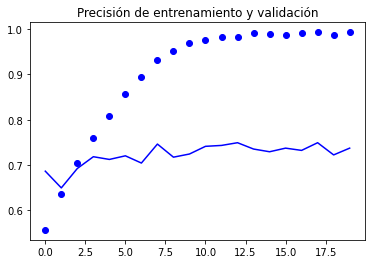

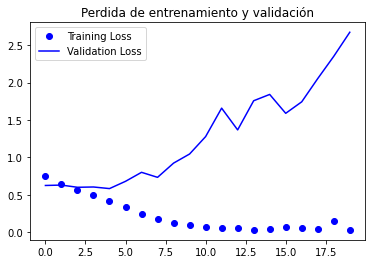

In [11]:
#-----------------------------------------------------------
# Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
#-----------------------------------------------------------
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Imprimir la precisión del entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Precisión de entrenamiento y validación')

plt.figure()

#------------------------------------------------
# Imprimir la perdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Perdida de entrenamiento y validación')
plt.legend()

plt.show()

Como se puede observar, este es un claro ejemplo de overfitting, algo que naturalmente se quiere evitar para que las redes neuronales sean lo más precisas posibles.

**Ejercicio 4 (3 puntos)**: Para soluciónar este problema, se debe rehacer algunas partes del código anterior utilizando las técnicas de regularización aprendidas en clase, como el data augmentation.

*Consejo*: Volver a escribir otra vez todas las secciones y cambiar el código necesario aplicando las técnicas de regularización elegidas. Se debe recordar que este tipo de técnicas se suele usar en el preprocesamiento de los datos.

*Aclaración*: Se espera que al menos se use una de las técnicas de regularización aprendidas en clase. Se valorará positivamente razonar el motivo del uso de la técnica escogida (o escogidas en el caso de ser varias) y no las otras.

A modo orientativo, se espera obtener un resultado gráfico similar a este:

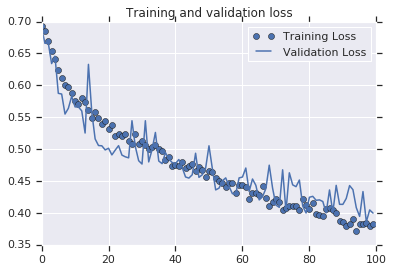
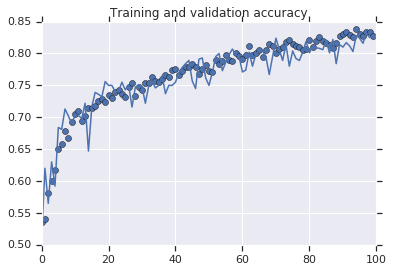

# Dropout Regularization & Image Data Augmentation

In [12]:
# Todas las imagenes tienen que ser reescaldas a 1./255.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                   )
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "train_datagen generator"
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flujo de imagenes de entrenamiento en batches de 20 usando el "test_datagen generator"
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# Modelo
model = tf.keras.models.Sequential([ 
    #Convolucional                                    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    #Capas
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=2000//20,
                              epochs=100,
                              validation_steps=1000//20,
                              verbose=2)

Epoch 1/100
100/100 - 17s - loss: 1.0545 - accuracy: 0.5630 - val_loss: 0.7788 - val_accuracy: 0.5010
Epoch 2/100
100/100 - 15s - loss: 0.8072 - accuracy: 0.6190 - val_loss: 3.4344 - val_accuracy: 0.5000
Epoch 3/100
100/100 - 15s - loss: 0.6947 - accuracy: 0.6465 - val_loss: 0.8646 - val_accuracy: 0.5140
Epoch 4/100
100/100 - 15s - loss: 0.6519 - accuracy: 0.6770 - val_loss: 0.8576 - val_accuracy: 0.5480
Epoch 5/100
100/100 - 15s - loss: 0.6187 - accuracy: 0.6765 - val_loss: 0.6333 - val_accuracy: 0.6720
Epoch 6/100
100/100 - 15s - loss: 0.5870 - accuracy: 0.6890 - val_loss: 0.8974 - val_accuracy: 0.6240
Epoch 7/100
100/100 - 15s - loss: 0.5540 - accuracy: 0.7235 - val_loss: 0.6255 - val_accuracy: 0.6820
Epoch 8/100
100/100 - 15s - loss: 0.5255 - accuracy: 0.7435 - val_loss: 0.5339 - val_accuracy: 0.7380
Epoch 9/100
100/100 - 15s - loss: 0.5370 - accuracy: 0.7315 - val_loss: 0.4927 - val_accuracy: 0.7560
Epoch 10/100
100/100 - 15s - loss: 0.4901 - accuracy: 0.7605 - val_loss: 0.5226 - 

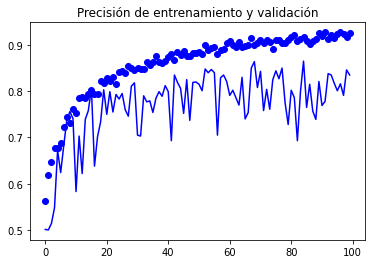

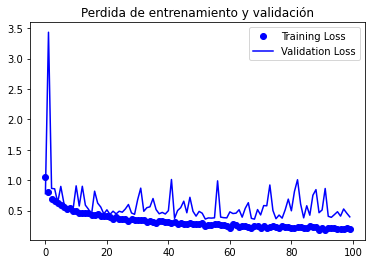

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Imprimir la precisión del entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Precisión de entrenamiento y validación')

plt.figure()

#------------------------------------------------
# Imprimir la perdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Perdida de entrenamiento y validación')
plt.legend()

plt.show()

# Optimizado

In [15]:
# Modelo
model2 = tf.keras.models.Sequential([ 
    #Convolucional                                    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    #Capas
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])



In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [17]:
history2 = model2.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=2000//20,
                              epochs=100,
                              validation_steps=1000//20,
                              verbose=2,
                              callbacks=[callbacks])

Epoch 1/100
100/100 - 16s - loss: 1.0326 - accuracy: 0.5870 - val_loss: 2.9958 - val_accuracy: 0.5000
Epoch 2/100
100/100 - 15s - loss: 0.8320 - accuracy: 0.6015 - val_loss: 1.3050 - val_accuracy: 0.5000
Epoch 3/100
100/100 - 15s - loss: 0.7375 - accuracy: 0.6170 - val_loss: 0.8460 - val_accuracy: 0.5040
Epoch 4/100
100/100 - 15s - loss: 0.6756 - accuracy: 0.6535 - val_loss: 0.7137 - val_accuracy: 0.5690
Epoch 5/100
100/100 - 15s - loss: 0.6215 - accuracy: 0.6755 - val_loss: 0.7792 - val_accuracy: 0.6000
Epoch 6/100
100/100 - 15s - loss: 0.5967 - accuracy: 0.7045 - val_loss: 0.6327 - val_accuracy: 0.6260
Epoch 7/100
100/100 - 15s - loss: 0.5595 - accuracy: 0.7175 - val_loss: 0.5739 - val_accuracy: 0.7160
Epoch 8/100
100/100 - 15s - loss: 0.5527 - accuracy: 0.7250 - val_loss: 0.4917 - val_accuracy: 0.7540
Epoch 9/100
100/100 - 15s - loss: 0.5271 - accuracy: 0.7515 - val_loss: 0.5229 - val_accuracy: 0.7440
Epoch 10/100
100/100 - 15s - loss: 0.5150 - accuracy: 0.7440 - val_loss: 0.5383 - 

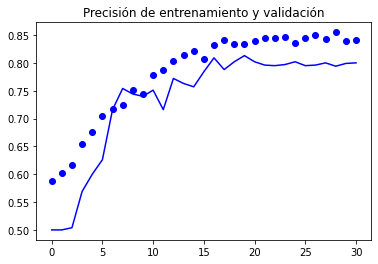

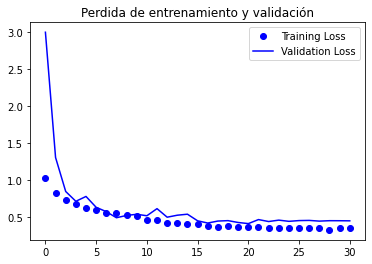

In [18]:


acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Imprimir la precisión del entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Precisión de entrenamiento y validación')

plt.figure()

#------------------------------------------------
# Imprimir la perdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Perdida de entrenamiento y validación')
plt.legend()

plt.show()